In [398]:
import re
from collections import Counter, defaultdict, deque
from functools import cmp_to_key, lru_cache, reduce
from itertools import count, cycle, islice, product, takewhile
from json import loads
from operator import mul
from re import match

import numpy as np
import portion as P
from matplotlib import pyplot as plt
from more_itertools import batched, sliding_window
from numba import njit
from tqdm.auto import tqdm
from z3 import Abs, And, Int, Ints, Not, Solver

# Day 1

In [435]:
calorie_counts = []
total = 0
with open("1.txt") as f:
    for line in f.readlines():
        if line == "\n":
            calorie_counts.append(total)
            total = 0
        else:
            total += int(line)

In [436]:
max(calorie_counts)

71506

In [437]:
sum(sorted(calorie_counts)[-3:])

209603

# Day 2

In [438]:
score = 0
with open("2.txt") as f:
    for line in f.readlines():
        a, bottom = line[0], line[2]
        a, bottom = ord(a) - ord("A"), ord(bottom) - ord("X")
        if a == bottom:
            score += 3 + bottom + 1
        elif (bottom - a) % 3 == 1:
            score += 6 + bottom + 1
        else:
            score += bottom + 1
score

14069

In [439]:
score = 0
with open("2.txt") as f:
    for line in f.readlines():
        a, right = line[0], line[2]
        a, right = ord(a) - ord("A"), ord(right) - ord("X")
        if right == 0:
            score += (a - 1) % 3 + 1
        elif right == 1:
            score += 3 + a + 1
        else:
            score += 6 + (a + 1) % 3 + 1
score

12411

# Day 3

In [440]:
def pri(c):
    if "a" <= c <= "z":
        return ord(c) - ord("a") + 1
    else:
        return ord(c) - ord("A") + 27

In [441]:
total = 0
with open("3.txt") as f:
    for line in f.readlines():
        items = tuple(map(pri, line[:-1]))
        half = len(items) // 2
        total += next(iter(set(items[:half]) & set(items[half:])))
total

7766

In [442]:
total = 0
with open("3.txt") as f:
    for lines in batched(f.readlines(), 3):
        items = tuple(set(map(pri, line[:-1])) for line in lines)
        total += next(iter(items[0] & items[1] & items[2]))
total

2415

# Day 4

In [443]:
ct = 0
with open("4.txt") as f:
    for line in f.readlines():
        a, bottom, c, d = map(int, match(r"(\d+)-(\d+),(\d+)-(\d+)", line).groups())
        if (a <= c and bottom >= d) or (c <= a and d >= bottom):
            ct += 1
ct

448

In [444]:
ct = 0
with open("4.txt") as f:
    for line in f.readlines():
        a, bottom, c, d = map(int, match(r"(\d+)-(\d+),(\d+)-(\d+)", line).groups())
        if not (bottom < c or d < a):
            ct += 1
ct

794

# Day 5

In [445]:
with open("5.txt") as f:
    it = iter(f.readlines())
    scans = []
    while "1" not in (line := next(it)):
        scans.append(line[1::4])
    stacks = [
        [scans[i][n] for i in range(7, -1, -1) if scans[i][n] != " "] for n in range(9)
    ]
    next(it)
    for line in it:
        n, a, bottom = map(int, match(r"move (\d+) from (\d) to (\d)", line).groups())
        for _ in range(n):
            stacks[bottom - 1].append(stacks[a - 1].pop())
"".join(stack.pop() for stack in stacks)

'FRDSQRRCD'

In [446]:
with open("5.txt") as f:
    it = iter(f.readlines())
    scans = []
    while "1" not in (line := next(it)):
        scans.append(line[1::4])
    stacks = [
        [scans[i][n] for i in range(7, -1, -1) if scans[i][n] != " "] for n in range(9)
    ]
    next(it)
    for line in it:
        n, a, bottom = map(int, match(r"move (\d+) from (\d) to (\d)", line).groups())
        temp = []
        for _ in range(n):
            temp.append(stacks[a - 1].pop())
        for _ in range(n):
            stacks[bottom - 1].append(temp.pop())
"".join(stack.pop() for stack in stacks)

'HRFTQVWNN'

# Day 6

In [447]:
with open("6.txt") as f:
    line = f.readline()

In [448]:
next(i + 4 for i, w in enumerate(sliding_window(line, 4)) if len(set(w)) == 4)

1794

In [449]:
next(i + 14 for i, w in enumerate(sliding_window(line, 14)) if len(set(w)) == 14)

2851

# Day 7

In [450]:
with open("7.txt") as f:
    wd = fs = {"/": {}}
    for line in f.readlines():
        if m := match(r"\$ cd (.+)", line):
            wd = wd[m[1]]
        elif line == "$ ls\n":
            pass
        elif m := match(r"dir (.+)", line):
            dirname = m[1]
            if dirname not in wd:
                wd[dirname] = {}
                wd[dirname][".."] = wd
        elif m := match(r"(\d+) (.+)", line):
            size, name = int(m[1]), m[2]
            wd[name] = size

In [451]:
def dirs(wd=fs):
    yield wd
    for k, v in wd.items():
        if k != ".." and type(v) == dict:
            yield from dirs(v)

In [452]:
def size(wd):
    return sum(size(v) if type(v) == dict else v for k, v in wd.items() if k != "..")

In [453]:
sum(size(d) for d in dirs() if size(d) <= 100_000)

1844187

In [454]:
min((size(d) for d in dirs() if size(d) >= 30000000 - (70000000 - size(fs))))

4978279

# Day 8

In [462]:
with open("8.txt") as f:
    lines = [list(map(int, line[:-1])) for line in f.readlines()]
    grid = np.array(lines)

In [466]:
ct = 0
for (right, c), v in np.ndenumerate(grid):
    try:
        if (
            v > grid[right, :c].max()
            or v > grid[right, c + 1 :].max()
            or v > grid[:right, c].max()
            or v > grid[right + 1 :, c].max()
        ):
            ct += 1
    except ValueError:  # handle sides
        ct += 1
ct

1693

In [467]:
def vd(h, a):
    r = sum(1 for _ in takewhile(lambda e: e < h, a))
    return r + 1 if r < len(a) and a[r] <= h else r

In [468]:
def score(r, c, v):
    try:
        return reduce(
            mul,
            (
                vd(v, a)
                for a in (
                    grid[r, :c][::-1],
                    grid[r, c + 1 :],
                    grid[:r, c][::-1],
                    grid[r + 1 :, c],
                )
            ),
        )
    except ValueError:
        return 0

In [469]:
max(score(r, c, v) for (r, c), v in np.ndenumerate(grid))

422059

# Day 9

In [453]:
with open("9.txt") as f:
    h = np.array([0, 0])
    top = np.array([0, 0])
    visited = set((tuple(top),))
    for line in f.readlines():
        d, n = match(r"(.) (\d+)", line).groups()
        d = np.array({"L": (-1, 0), "R": (1, 0), "U": (0, 1), "D": (0, -1)}[d])
        n = int(n)
        for _ in range(n):
            h += d
            if np.abs(top - h).max() == 2:
                dx = 1 if h[0] > top[0] else -1 if h[0] < top[0] else 0
                dy = 1 if h[1] > top[1] else -1 if h[1] < top[1] else 0
                top += np.array([dx, dy])
                visited.add(tuple(top))
len(visited)

6018

In [454]:
with open("9.txt") as f:
    k = [np.array([0, 0]) for _ in range(10)]
    visited = set((tuple(k[9]),))
    for line in f.readlines():
        d, n = match(r"(.) (\d+)", line).groups()
        d = np.array({"L": (-1, 0), "R": (1, 0), "U": (0, 1), "D": (0, -1)}[d])
        n = int(n)
        for _ in range(n):
            k[0] += d
            for i in range(1, 10):
                h, top = k[i - 1], k[i]
                if np.abs(top - h).max() == 2:
                    dx = 1 if h[0] > top[0] else -1 if h[0] < top[0] else 0
                    dy = 1 if h[1] > top[1] else -1 if h[1] < top[1] else 0
                    top += np.array([dx, dy])
            visited.add(tuple(k[9]))
len(visited)

2619

# Day 10

In [472]:
with open("10.txt") as f:
    xs = [None]
    x = 1
    for line in f.readlines():
        if m := match(r"addx (-?\d+)", line):
            xs.extend((x, x))
            x += int(m[1])
        elif line == "noop\n":
            xs.append(x)

In [473]:
sum(xs[i] * i for i in (20, 60, 100, 140, 180, 220))

17380

In [474]:
for right in range(6):
    for c in range(40):
        if abs(c - xs[right * 40 + c + 1]) <= 1:
            print("#", end="")
        else:
            print(".", end="")
    print()

####..##...##..#..#.####.###..####..##..
#....#..#.#..#.#..#....#.#..#.#....#..#.
###..#....#....#..#...#..#..#.###..#....
#....#.##.#....#..#..#...###..#....#....
#....#..#.#..#.#..#.#....#.#..#....#..#.
#.....###..##...##..####.#..#.####..##..


# Day 11

In [475]:
with open("11.txt") as f:
    items = []
    acts = []
    factors = []
    trues = []
    falses = []
    for i in range(8):
        f.readline()
        line = f.readline()
        s = match(r" +Starting items: (.+)", line)[1]
        items.append(list(map(int, s.split(", "))))
        line = f.readline()
        act = match(r" +Operation: new = (.+)", line)[1]
        act = eval(f"lambda old: {act}")
        acts.append(act)
        line = f.readline()
        factors.append(int(match(r" +Test: divisible by (\d+)", line)[1]))
        line = f.readline()
        trues.append(int(match(r" +If true: throw to monkey (\d)", line)[1]))
        line = f.readline()
        falses.append(int(match(r" +If false: throw to monkey (\d)", line)[1]))
        f.readline()

In [476]:
counts = [0] * 8
for _ in range(20):
    for i in range(8):
        for j in items[i]:
            counts[i] += 1
            new = acts[i](j)
            new //= 3
            if new % factors[i] == 0:
                items[trues[i]].append(new)
            else:
                items[falses[i]].append(new)
        items[i] = []

In [477]:
a, bottom = sorted(counts)[-2:]
a * bottom

57838

In [478]:
with open("11.txt") as f:
    items = []
    acts = []
    factors = []
    trues = []
    falses = []
    for i in range(8):
        f.readline()
        line = f.readline()
        s = match(r" +Starting items: (.+)", line)[1]
        items.append(list(map(int, s.split(", "))))
        line = f.readline()
        act = match(r" +Operation: new = (.+)", line)[1]
        act = eval(f"lambda old: {act}")
        acts.append(act)
        line = f.readline()
        factors.append(int(match(r" +Test: divisible by (\d+)", line)[1]))
        line = f.readline()
        trues.append(int(match(r" +If true: throw to monkey (\d)", line)[1]))
        line = f.readline()
        falses.append(int(match(r" +If false: throw to monkey (\d)", line)[1]))
        f.readline()
    items = list(list(list(y % f for f in factors) for y in x) for x in items)

In [479]:
counts = [0] * 8
for _ in range(10_000):
    for i in range(8):
        for j in items[i]:
            counts[i] += 1
            new = [acts[i](x) % f for x, f in zip(j, factors)]
            if new[i] == 0:
                items[trues[i]].append(new)
            else:
                items[falses[i]].append(new)
        items[i].clear()

In [480]:
a, bottom = sorted(counts)[-2:]
a * bottom

15050382231

# Day 12

In [445]:
with open("12.txt") as f:
    grid = [[ord(c) - ord("a") for c in line[:-1]] for line in f.readlines()]

In [446]:
grid = np.array(grid)
h, w = grid.shape
start = tuple(np.argwhere(grid == ord("S") - ord("a"))[0])
end = tuple(np.argwhere(grid == ord("E") - ord("a"))[0])
grid[start], grid[end] = 0, 25

In [449]:
def search():
    distances = np.zeros_like(grid)
    distances.fill(h * w)
    front = [start]
    for distance in count(1):
        new_front = []
        for r, c in front:
            for dr, dc in ((0, 1), (0, -1), (1, 0), (-1, 0)):
                new = (r + dr, c + dc)
                if not (0 <= new[0] < h and 0 <= new[1] < w):
                    continue
                if grid[new] <= 1 + grid[r, c] and distance < distances[new]:
                    new_front.append(new)
                    distances[new] = distance
                    if new == end:
                        return distance
        front = new_front

In [450]:
search()

447

In [451]:
def search():
    distances = np.zeros_like(grid)
    distances.fill(h * w)
    front = [end]
    for distance in count(1):
        new_front = []
        for r, c in front:
            for dr, dc in ((0, 1), (0, -1), (1, 0), (-1, 0)):
                new = (r + dr, c + dc)
                if not (0 <= new[0] < h and 0 <= new[1] < w):
                    continue
                if grid[new] >= grid[r, c] - 1 and distance < distances[new]:
                    new_front.append(new)
                    distances[new] = distance
                    if grid[new] == 0:
                        return distance
        front = new_front

In [452]:
search()

446

# Day 13

In [441]:
def cmp(left, right):
    if type(left) == int and type(right) == int:
        return -1 if left < right else 0 if left == right else 1
    if type(left) == list and type(right) == list:
        for a, b in zip(left, right):
            if (r := cmp(a, b)) != 0:
                return r
        return -1 if len(left) < len(right) else 0 if len(left) == len(right) else 1
    return cmp([left], right) if type(left) == int else cmp(left, [right])

In [442]:
with open("13.txt") as f:
    right = 0
    for i, (a, bottom, _) in enumerate(batched(f.readlines() + ["\n"], 3)):
        right += i + 1 if cmp(loads(a), loads(bottom)) == -1 else 0
right

6272

In [443]:
with open("13.txt") as f:
    packets = []
    for i, (a, bottom, _) in enumerate(batched(f.readlines() + ["\n"], 3)):
        packets.extend((loads(a), loads(bottom)))

In [444]:
packets.extend(([[2]], [[6]]))
packets.sort(key=cmp_to_key(cmp))
(packets.index([[2]]) + 1) * (packets.index([[6]]) + 1)

22288

# Day 14

In [422]:
with open("14.txt") as f:
    polygons = []
    for line in f.readlines():
        polygons.append([[int(s) for s in s.split(",")] for s in line.split(" -> ")])

In [423]:
xmin, xmax = (f(pt[0] for p in polygons for pt in p) for f in (min, max))
ymin, ymax = (f(pt[1] for p in polygons for pt in p) for f in (min, max))
cave = np.zeros((ymax + 1, xmax - xmin + 2), dtype=np.bool_)

In [424]:
for p in polygons:
    for (ax, ay), (bx, by) in list(sliding_window(p, 2)):
        if ax == bx:
            cave[min(ay, by) : max(ay, by) + 1, ax - xmin] = True
        else:
            cave[ay, min(ax, bx) - xmin : max(ax, bx) - xmin + 1] = True

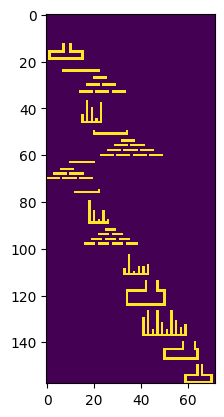

In [425]:
plt.imshow(cave, interpolation="nearest")
plt.show()

In [426]:
for grains in count():
    x, y = 500 - xmin, 0
    while y < ymax:
        try:
            possible = ((x, y + 1), (x - 1, y + 1), (x + 1, y + 1))
            x, y = next((a, b) for a, b in possible if not cave[b, a])
        except StopIteration:
            cave[y, x] = True
            break
    if y == ymax:
        break

In [428]:
grains

696

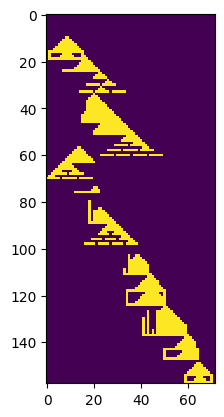

In [429]:
plt.imshow(cave, interpolation="nearest")
plt.show()

In [430]:
with open("14.txt") as f:
    polygons = []
    for line in f.readlines():
        polygons.append([[int(s) for s in s.split(",")] for s in line.split(" -> ")])

In [431]:
xmin, xmax = (f(pt[0] for p in polygons for pt in p) for f in (min, max))
ymin, ymax = (f(pt[1] for p in polygons for pt in p) for f in (min, max))
ymax += 2
xmin, xmax = 500 - ymax - 10, 500 + ymax + 10
cave = np.zeros((ymax + 1, xmax - xmin + 2), dtype=np.bool_)

In [432]:
for p in polygons:
    for (ax, ay), (bx, by) in list(sliding_window(p, 2)):
        if ax == bx:
            cave[min(ay, by) : max(ay, by) + 1, ax - xmin] = True
        else:
            cave[ay, min(ax, bx) - xmin : max(ax, bx) - xmin + 1] = True

In [433]:
cave[ymax, :] = True

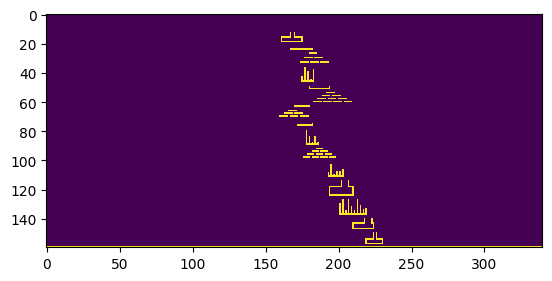

In [434]:
plt.imshow(cave, interpolation="nearest")
plt.show()

In [435]:
for grains in count(1):
    x, y = 500 - xmin, 0
    while True:
        try:
            possible = ((x, y + 1), (x - 1, y + 1), (x + 1, y + 1))
            x, y = next((a, b) for a, b in possible if not cave[b, a])
        except StopIteration:
            cave[y, x] = True
            break
    if y == 0:
        break

In [436]:
grains

23610

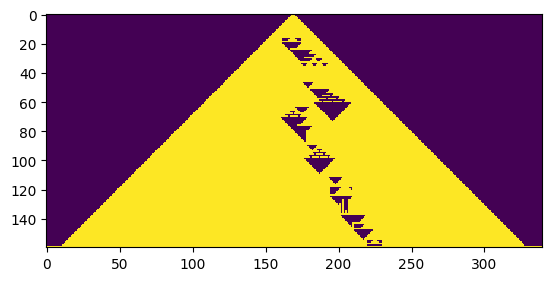

In [437]:
plt.imshow(cave, interpolation="nearest")
plt.show()

# Day 15

In [399]:
with open("15.txt") as f:
    covered = P.empty()
    beacons = set()
    for line in f.readlines():
        pattern = "Sensor at x=(.+), y=(.+): closest beacon is at x=(.+), y=(.+)"
        sx, sy, bx, by = map(int, match(pattern, line).groups())
        if by == 2000000:
            beacons.add(bx)
        md = abs(sx - bx) + abs(sy - by)
        if (d := abs(sy - 2000000)) <= md:
            xmin, xmax = sx - md + d, sx + md - d
            covered |= P.closed(xmin, xmax)

In [400]:
covered

[-792660,4373417]

In [401]:
covered.upper - covered.lower + 1 - len(beacons)

5166077

In [405]:
solver = Solver()
x, y = Ints("x y")
solver.add(0 <= x, x <= 4_000_000, 0 <= y, y <= 4_000_000)

In [406]:
with open("15.txt") as f:
    for line in f.readlines():
        pattern = "Sensor at x=(.+), y=(.+): closest beacon is at x=(.+), y=(.+)"
        sx, sy, bx, by = map(int, match(pattern, line).groups())
        if 0 <= bx <= 4_000_000 and 0 <= by <= 4_000_000:
            solver.add(Not(And(x == bx, y == by)))
        md = abs(sx - bx) + abs(sy - by)
        solver.add(Abs(x - sx) + Abs(y - sy) > md)

In [407]:
solver.check()
x, y = [solver.model().eval(v) for v in (x, y)]
x.as_long() * 4_000_000 + y.as_long()

13071206703981

# Day 16

In [47]:
with open("16.txt") as f:
    volcano = {}
    for line in f.readlines():
        name, rate, valves = match(
            "Valve (..) has flow rate=(\d+); tunnels? leads? to valves? (.+)", line
        ).groups()
        rate = int(rate)
        valves = valves.split(", ")
        volcano[name] = (rate, valves)

names = list(volcano.keys())

volcano = [(r, [names.index(n) for n in v]) for _, (r, v) in volcano.items()]

In [48]:
@lru_cache(maxsize=None)
def most(time=30, opened=0, pos=names.index("AA")):
    if time == 0:
        return 0
    r = max(most(time - 1, opened, valve) for valve in volcano[pos][1])
    flow = volcano[pos][0]
    if flow and (1 << pos) & ~opened:
        s = flow * (time - 1) + most(time - 1, opened | (1 << pos), pos)
        r = max(r, s)
    return r

In [49]:
most()

1617

In [63]:
@lru_cache(maxsize=None)
def most(time=26, opened=0, p1=names.index("AA"), p2=names.index("AA")):
    if time == 0:
        return 0
    r = max(
        most(time - 1, opened, *sorted((v1, v2)))
        for v1, v2 in product(volcano[p1][1], volcano[p2][1])
    )
    f1, f2 = volcano[p1][0], volcano[p2][0]
    if f1 and (1 << p1) & ~opened:
        s = f1 * (time - 1) + max(
            most(time - 1, opened | (1 << p1), *sorted((p1, v2)))
            for v2 in volcano[p2][1]
        )
        r = max(r, s)
    if f2 and (1 << p2) & ~opened:
        s = f2 * (time - 1) + max(
            most(time - 1, opened | (1 << p2), *sorted((v1, p2)))
            for v1 in volcano[p1][1]
        )
        r = max(r, s)
    if f1 and f2 and ((1 << p1) & ~opened) and ((1 << p2) & ~opened) and p1 != p2:
        s = (f1 + f2) * (time - 1) + most(
            time - 1, opened | (1 << p1) | (1 << p2), p1, p2
        )
        r = max(r, s)
    return r


%time most()

CPU times: user 8min 4s, sys: 11.4 s, total: 8min 15s
Wall time: 8min 28s


2171

# Day 17

In [394]:
shapes = []
for lines in """####

.#.
###
.#.

..#
..#
###

#
#
#
#

##
##""".split(
    "\n\n"
):
    shape = lines.split("\n")
    h, w = len(shape), len(shape[0])
    shape = np.fromiter((c == "#" for w in shape[::-1] for c in w), np.bool_)
    shape = shape.reshape(h, w)
    shapes.append(shape)

In [395]:
with open("17.txt") as f:
    jets = f.readline()[:-1]

In [396]:
chamber = np.zeros((8088, 7), np.bool_)
top = 0
jet_it = cycle(jets)
shape_it = cycle(shapes)
for shape in islice(shape_it, 2022):
    x, y = 2, top + 3
    h, w = shape.shape
    while True:
        jet = next(jet_it)
        x1, y1 = x + (-1 if jet == "<" else 1), y - 1
        if 0 <= x1 <= 7 - w:
            if not (shape * chamber[y : y + h, x1 : x1 + w]).any():
                x = x1
        if y1 >= 0 and not (shape * chamber[y1 : y1 + h, x : x + w]).any():
            y = y1
        else:
            top = max(top, y + h)
            chamber[y : y + h, x : x + w] |= shape
            break

In [397]:
top

3124

In [73]:
chamber = np.zeros((400_000, 7), np.bool_)
top = 0
jet_it = cycle(jets)
shape_it = cycle(shapes)
steps = []
for shape in islice(shape_it, 100_000):
    x, y = 2, top + 3
    h, w = shape.shape
    while True:
        jet = next(jet_it)
        x1, y1 = x + (-1 if jet == "<" else 1), y - 1
        if 0 <= x1 <= 7 - w:
            if not (shape * chamber[y : y + h, x1 : x1 + w]).any():
                x = x1
        if y1 >= 0 and not (shape * chamber[y1 : y1 + h, x : x + w]).any():
            y = y1
        else:
            newtop = max(top, y + h)
            steps.append(newtop - top)
            top = newtop
            chamber[y : y + h, x : x + w] |= shape
            break

In [74]:
dd = defaultdict(lambda: [])
for i, w in enumerate(sliding_window(steps, 1700)):
    dd[w].append(i)

In [75]:
max(dd.items(), key=lambda kv: len(kv[1]))[1][0:2]

[657, 2357]

In [77]:
div, mod = divmod(1000000000000 - 657, 1700)
sum(steps[0:657]) + div * sum(steps[657:2357]) + sum(steps[657 : 657 + mod])

1561176470569

# Day 18

In [389]:
with open("18.txt") as f:
    cubes = set(tuple(map(int, line.split(","))) for line in f.readlines())

In [391]:
faces = 0
for cube in cubes:
    for a in range(3):
        for d in (-1, 1):
            top = cube[:a] + (cube[a] + d,) + cube[a + 1 :]
            if top not in cubes:
                faces += 1

faces

3610

In [379]:
[[f(t[a] for t in cubes) for f in (min, max)] for a in range(3)]

[[1, 19], [0, 19], [0, 18]]

In [380]:
front = [(-1, -1, -1)]
fill = set(front)
while front:
    newfront = []
    for cube in front:
        for a in range(3):
            for d in (-1, 1):
                top = cube[:a] + (cube[a] + d,) + cube[a + 1 :]
                if not all(-1 <= n <= 20 for n in top):
                    continue
                if top not in cubes and top not in fill:
                    fill.add(top)
                    newfront.append(top)
    front = newfront

In [392]:
faces = 0
for cube in cubes:
    for a in range(3):
        for d in (-1, 1):
            top = cube[:a] + (cube[a] + d,) + cube[a + 1 :]
            if top not in cubes and top not in fill:
                faces += 1

In [393]:
3610 - faces

2082

# Day 19

In [353]:
with open("19.txt") as f:
    bps = []
    pat = "Blueprint \d+: Each ore robot costs (\d+) ore. Each clay robot costs (\d+) ore. \
Each obsidian robot costs (\d+) ore and (\d+) clay. Each geode robot costs (\d+) ore and (\d+) obsidian."
    for line in f.readlines():
        bp = np.zeros((4, 3), dtype=np.int_)
        m = map(int, match(pat, line).groups())
        bp[0, 0], bp[1, 0], bp[2, 0], bp[2, 1], bp[3, 0], bp[3, 2] = m
        bps.append(bp)

In [364]:
def best(bp):
    m = 0

    @njit
    def helper(t=24, res=np.array((0, 0, 0)), rob=np.array((1, 0, 0, 0))):
        nonlocal m
        if t == 0:
            return 0
        if t * (rob[3] + t - 1) <= m + m:
            return 0
        r = 0
        built = False
        for d in range(3, -1, -1):
            if ((rob[:3] == 0) & (bp[d] > 0)).any():
                continue
            if d < 3 and rob[d] == max(bp[d + 1 :, d]):
                continue
            e = max(d, 1)
            ttb = max(max((bp[d, :e] - res[:e] + rob[:e] - 1) // rob[:e]), 0)
            if ttb + 8 - d - d > t:
                continue
            built = True
            newres = res + rob[:3] * (ttb + 1) - bp[d]
            newrob = rob.copy()
            newrob[d] += 1
            g = rob[3] * (ttb + 1)
            m -= g
            r = max(r, g + helper(t - ttb - 1, newres, newrob))
            m += g
        if not built:
            return rob[3] * t
        return r

    return helper()

In [365]:
sum((i + 1) * best(bp) for i, bp in enumerate(tqdm(bps)))

  0%|          | 0/30 [00:00<?, ?it/s]

1565

In [371]:
def best(bp):
    @njit
    def helper(t=32, res=np.array((0, 0, 0)), rob=np.array((1, 0, 0, 0))):
        if t == 0:
            return 0
        r = 0
        built = False
        for d in range(3, -1, -1):
            if ((rob[:3] == 0) & (bp[d] > 0)).any():
                continue
            if d < 3 and rob[d] == max(bp[d + 1 :, d]):
                continue
            e = max(d, 1)
            ttb = max(max((bp[d, :e] - res[:e] + rob[:e] - 1) // rob[:e]), 0)
            if ttb + 8 - d - d > t:
                continue
            built = True
            newres = res + rob[:3] * (ttb + 1) - bp[d]
            newrob = rob.copy()
            newrob[d] += 1
            g = rob[3] * (ttb + 1)
            r = max(r, g + helper(t - ttb - 1, newres, newrob))
        if not built:
            return rob[3] * t
        return r

    return helper()

In [374]:
reduce(mul, map(best, tqdm(bps[:3])))

  0%|          | 0/3 [00:00<?, ?it/s]

10672

# Day 20

In [350]:
with open("20.txt") as f:
    items = list(map(int, f.readlines()))

items = [811589153 * item for item in items]  # only part 2
L = len(items)
L1 = L - 1
poi = list(range(L))
iop = list(range(L))

In [351]:
for _ in range(10):  # use 1 for part 1
    for i in range(L):
        j = poi[i]
        k = (j + items[i]) % L1
        if j != k:
            if j < k:
                iop[j:k], iop[k] = iop[j + 1 : k + 1], iop[j]
            else:
                j, k = k, j
                iop[j + 1 : k + 1], iop[j] = iop[j:k], iop[k]
            for n in range(j, 1 + k):
                poi[iop[n]] = n

In [352]:
pz = poi[items.index(0)]
sum(items[iop[(pz + k) % L]] for k in (1000, 2000, 3000))

7865110481723

# Day 21

In [344]:
with open("21.txt") as f:
    lines = {}
    for line in f.readlines():
        name, expr = match(r"(.+): (.+)", line).groups()
        lines[name] = expr

In [345]:
solver = Solver()
symbols = {name: Int(name) for name in lines}
for name, expr in lines.items():
    solver.add(symbols[name] == eval(expr, symbols))

solver.check()
solver.model().eval(symbols["root"])

232974643455000

In [346]:
solver = Solver()
symbols = {name: Int(name) for name in lines}
for name, expr in lines.items():
    if name == "root":
        expr = f"{expr[:4]} == {expr[-4:]}"
        solver.add(eval(expr, symbols))
    elif name != "humn":
        solver.add(symbols[name] == eval(expr, symbols))
        if "/" in expr:  # Z3 does integer division on integers
            solver.add(symbols[expr[:4]] % symbols[expr[-4:]] == 0)

solver.check()
solver.model().eval(symbols["humn"])

3740214169961

# Day 22

In [331]:
with open("22.txt") as f:
    lines = [line[:-1] for line in f.readlines()]

In [332]:
lines, moves = lines[:-2], lines[-1]
dim = np.array((len(lines), max(len(line) for line in lines)))
lines = [line + " " * max(0, dim[1] - len(line)) for line in lines]

In [333]:
def mapfwd(pos, d):
    res = (pos + d) % dim
    while lines[res[0]][res[1]] == " ":
        res = (res + d) % dim
    return res

In [335]:
pos = np.array((0, lines[0].find(".")))
d = (0, 1)
ds = ((0, 1), (1, 0), (0, -1), (-1, 0))
for n, turn in batched(re.findall("\d+|L|R|x", moves + "x"), 2):
    for _ in range(int(n)):
        newpos = mapfwd(pos, d)
        if lines[newpos[0]][newpos[1]] != "#":
            pos = newpos
    if turn and turn in "LR":
        d = ds[(ds.index(d) + (1 if turn == "R" else -1)) % 4]

1000 * (pos[0] + 1) + 4 * (pos[1] + 1) + ds.index(d)

1484

In [336]:
size = min(len(line.replace(" ", "")) for line in lines)
size2 = size * 2

In [337]:
def normal(pos):
    d = next(d for d in range(3) if pos[d] in (0, size2))
    r = np.array((0, 0, 0))
    r[d] = 1 if pos[d] else -1
    return r

In [338]:
def cubefwd(pos, d):
    pos = pos + d
    if not all(0 <= c <= size2 for c in pos):
        newd = -normal(pos) * 2
        pos += (newd - d) // 2
        d = newd
    return pos, d

In [339]:
def right(pos, d):
    return np.cross(d, normal(pos))

In [340]:
def left(pos, d):
    return -right(pos, d)

In [341]:
pos = np.array((0, lines[0].find(".")))
d = (0, 1)
cp = np.array((1, 1, size2))
cd = np.array((0, 2, 0))
unfold = {}


def walk(cp, cd, p, d):
    work = deque(((cp, cd, p, d),))
    while work:
        cp, cd, p, d = work.pop()
        if (0 <= p).all() and (p < dim).all() and lines[p[0]][p[1]] != " ":
            ix = (tuple(cp), tuple(cd))
            if ix not in unfold:
                unfold[ix] = (p, d)
                work.append((*cubefwd(cp, cd), p + d, d))
                work.append((cp, right(cp, cd), p, ds[(ds.index(d) + 1) & 3]))


walk(cp, cd, pos, d)

In [342]:
cp = np.array((1, 1, size2))
cd = np.array((0, 2, 0))
for n, turn in batched(re.findall("\d+|L|R|x", moves + "x"), 2):
    for _ in range(int(n)):
        newp, nd = cubefwd(cp, cd)
        newpos = unfold[(tuple(newp), tuple(nd))][0]
        if lines[newpos[0]][newpos[1]] != "#":
            cp, cd = newp, nd
    if turn in "LR":
        cd = right(cp, cd) if turn == "R" else left(cp, cd)

pos, d = unfold[(tuple(cp), tuple(cd))]
1000 * (pos[0] + 1) + 4 * (pos[1] + 1) + ds.index(d)

142228

# Day 23

In [306]:
with open("23.txt") as f:
    lines = [line[:-1] for line in f.readlines()]

grove = set((r, c) for r, l in enumerate(lines) for c, ch in enumerate(l) if ch == "#")
compass = tuple(product((0, 1), (-1, 1)))

In [307]:
def step():
    global grove, compass
    newgrove = set()
    active = []
    for r, c in grove:
        for dr, dc in product((-1, 0, 1), repeat=2):
            if not (dr == dc == 0) and (r + dr, c + dc) in grove:
                active.append((r, c))
                break
        else:
            newgrove.add((r, c))
    wishers = []
    meets = Counter()
    for dim, dis in compass:
        wishing, newactive = [], []
        for r, c in active:
            for x in (-1, 0, 1):
                p = (r + x, c + dis) if dim else (r + dis, c + x)
                if p in grove:
                    newactive.append((r, c))
                    break
            else:
                wishing.append((r, c))
        active = newactive
        wishers.append(wishing)
        for r, c in wishing:
            p = (r, c + dis) if dim else (r + dis, c)
            meets[p] += 1
    for (dim, dis), m in zip(compass, wishers):
        for r, c in m:
            p = (r, c + dis) if dim else (r + dis, c)
            newgrove.add((r, c) if meets[p] > 1 else p)
    newgrove.update(active)
    if grove == newgrove:
        return True
    grove = newgrove
    compass = compass[1:] + (compass[0],)

In [308]:
for _ in range(10):
    step()

In [309]:
top = min(r for r, c in grove)
bottom = max(r for r, c in grove) + 1
left = min(c for r, c in grove)
right = max(c for r, c in grove) + 1
(bottom - top) * (right - left) - len(grove)

4336

In [310]:
for steps in count(11):
    if step():
        break
steps

1005

# Day 24

In [252]:
with open("24.txt") as f:
    lines = [line[:-1] for line in f.readlines()]

In [253]:
h, w = len(lines), len(lines[0])

In [254]:
up = ~np.array([[c == "^" for c in line] for line in lines])[1:-1, 1:-1]
dn = ~np.array([[c == "v" for c in line] for line in lines])[1:-1, 1:-1]
lt = ~np.array([[c == "<" for c in line] for line in lines])[1:-1, 1:-1]
rt = ~np.array([[c == ">" for c in line] for line in lines])[1:-1, 1:-1]

In [255]:
reached = np.zeros((h, w), np.bool_)
reached[0, 1] = True
for top in count(1):
    reaching = reached.copy()
    window = reaching[1:-1, 1:-1]
    for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        window |= reached[1 + d[0] : -1 + d[0] + h, 1 + d[1] : -1 + d[1] + w]
    for args in ((up, -top, 0), (dn, top, 0), (lt, -top, 1), (rt, top, 1)):
        window &= np.roll(*args)
    reaching[-1, -2] = reached[-2, -2]
    reached = reaching
    if reached[-1, -2]:
        break
top

238

In [256]:
reached = np.zeros((3, h, w), np.bool_)
reached[0, 0, 1] = True
for top in count(1):
    reaching = reached.copy()
    window = reaching[:, 1:-1, 1:-1]
    for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        window |= reached[:, 1 + d[0] : -1 + d[0] + h, 1 + d[1] : -1 + d[1] + w]
    for args in ((up, -top, 0), (dn, top, 0), (lt, -top, 1), (rt, top, 1)):
        window &= np.roll(*args)
    reaching[1, -1, -2] |= reached[0, -2, -2]
    reaching[2, 0, 1] |= reached[1, 1, 1]
    reaching[2, -1, -2] = reached[2, -2, -2]
    reached = reaching
    if reached[2, -1, -2]:
        break
top

751

# Day 25

In [237]:
def fromsnafu(s):
    return reduce(lambda r, c: 5 * r + "=-012".index(c) - 2, s, 0)

In [238]:
def tosnafu(n):
    d, m = divmod(n, 5)
    return tosnafu(d + (m > 2)) + "012=-"[m] if n else ""

In [239]:
with open("25.txt") as f:
    print(tosnafu(sum(fromsnafu(line[:-1]) for line in f.readlines())))

2-=102--02--=1-12=22
